# Introduction
Computers have become essential elements in modern societies, allowing us to efficiently solve numerous problems. Nonetheless, there are certain tasks of great interest that cannot even be solved with the most advanced supercomputers. The idea of quantum computing
first emerged in the context of using a quantum device to study systems governed by the laws of quantum mechanics in view of the difficulties of classical computers to simulate such behaviours. Over the years, and after it had been shown that a quantum computer could theoretically bring an exponential reduction in computation time for certain problems, the efforts for developing this new computing paradigm have increased considerably, with an special focus in the advancement of the quantum hardware and the
search of practical applications that go beyond artificial proof-of-concepts, also known as quantum advantage. 

For classical computers the minimum unit of information is a bit, which can be either in the 0 or the 1 configuration. For a quantum computer the analogous unit of quantum information is a qubit, a two-level quantum system that can be in any combination of the states |0⟩ and |1⟩. The potential of quantum computation relies on the quantum properties of qubits such as entanglement, superposition or tunnelling effects which build up a quantum logic that allows to manipulate the information in a more efficient manner than classical logic. The hardware implementation of a qubit remains a very
challenging and still open task, with many different approaches competing to enhance qubit control and reduce the noise from the environment, e.g. superconducting qubits, trapped ions, neutral atoms, optical qubits, among others.There are also different proposed models of quantum computation but two main paradigms prevail. The most popular one is the so-called gate-based model, or digital model, in which the problem is encoded in a sequence of quantum logic gates that canbe understood mathematically as unitary operators applied to a set of qubits. There are several sets of single and two-qubit gates that are known for being able to perform universal computation, i.e., any quantum problem can be encoded in a sequence of such set of gates. 

From the analogue side, we have the adiabatic quantum computing model, in which instead of encoding the problem in a quantum circuit, we design a Hamiltonian whose ground state encodes the solution of the problem we are aiming to solve. Even though in Qilimanjaro we are developing an analogue quantum computer based on superconducting circuits, we also have access a digital quantum computer, which is the formalism that we will use for this challenge. 

## Qubit routing problem
 In the digital model of quantum computation, an crucial type of operation to interact between qubits are the **two-qubit gates**, which act on one or two qubits at a time. However, in realistic hardware the qubits are typically laid out in a fixed two or three dimensional topology where gates may only be applied between neighbouring qubits. In order for a circuit to be executed on such hardware, it must be modified to ensure that whenever two qubits are required to interact, they are adjacent in memory.
 We refer to the task of modifying a circuit to conform to the memory layout of a specific quantum computer as the qubit routing problem. When non-adjacent qubits are required to interact we can insert additional SWAP gates to exchange a qubit with a neighbour, moving it closer to its desired partner. In general many – or even all – of the qubits may need to be swapped, making this problem non-trivial. Since quantum algorithms are usually designed without reference to the connectivity constraints of any particular hardware, a solution to the routing problem is required before a quantum circuit can be executed. Therefore qubit routing forms a necessary stage of any compiler for quantum software.

 Current quantum computers – the so-called NISQ (Noisy Intermediate Scale Quantum) devices – impose additional constraints. Their short coherence times and relatively low fidelity gates require that the circuit depth and the total number of gates are both as low as possible. As routing generally introduces extra gates into a circuit, increasing its size and depth, it is crucial that the circuit does not grow too much, or its performance will be compromised.

We represent a quantum computer as a graph where nodes are physical qubits and edges are the allowed 2-qubit interactions. Since the circuit model assumes we can realise a two-qubit gate between any pair of qubits, it is equivalent to the complete graph (Fig. 2a). Realistic qubit
architectures are connectivity limited: for instance, in most superconducting platforms the qubit interaction graph must be planar; ion traps present more flexibility, but are still not fully connected. For now we will use the ring graph (Fig. 2b) as a simple example. Given such a restricted graph, our goal is to emulate the complete graph with minimal additional cost. 

From this point of view, the routing problem can be stated as follows. Given *(i)* an arbitrary quantum circuit and *(ii)* a connected graph specifying the allowed qubit interactions, we must produce a new quantum circuit which is equivalent to the input circuit, but uses only those interactions permitted by the specification graph. Provided the device has at least as many qubits as the input circuit then a solution always exists; our objective is to minimise the size of the output circuit.


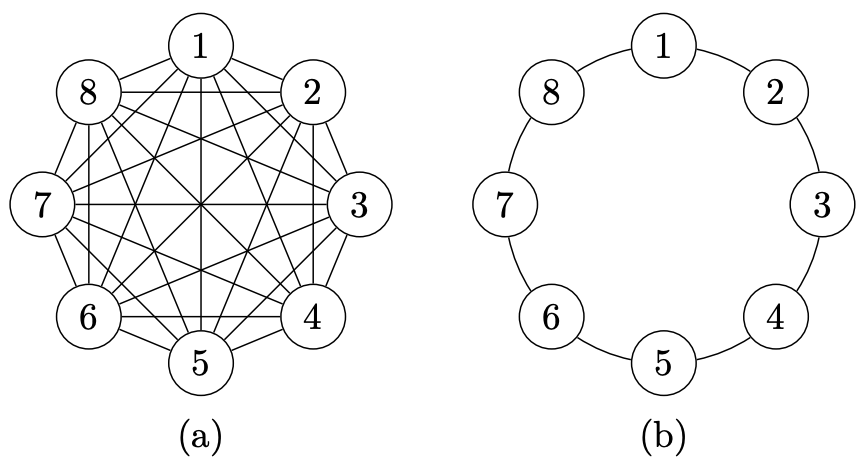

In [63]:
from IPython.display import Image
Image("images/FIG1.png", width=600, height=600)

FIG.1 Nodes in the graph represent physical qubits and edges are the allowed interactions. (a) The circuit
model assumes all-to-all communication between qubits, *i.e*. a complete graph and (b) a physically realistic
one-dimensional nearest neighbour cyclic graph, the ring.

## A. Example: routing on a ring

Let’s consider the problem of routing the following circuit (FIG.2) on the ring graph of FIG. 1(b). 

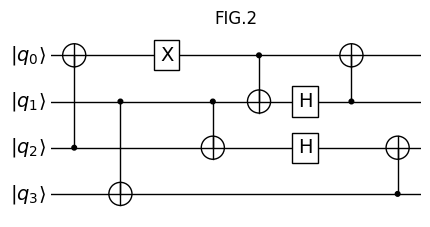

In [53]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(4)
c.add(gates.CNOT(2,0))
c.add(gates.CNOT(1,3))
c.add(gates.X(0))
c.add(gates.CNOT(1,2))
c.add(gates.CNOT(0,1))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1,0))
c.add(gates.CNOT(3,2))
ax, fig = plot_circuit(c)
ax.set_title('FIG.2')
plt.show()

The first step is to divide the circuit into timesteps, also called slices. Loosely speaking, a timestep consists of a subcircuit where the gates act on disjoint sets of qubits and could in principle all be performed simultaneously. The single qubit gates have no bearing on the routing problem so can be ignored, and thus a timestep can be reduced to a set of qubit pairs that are required to interact via some 2-qubit gate. 

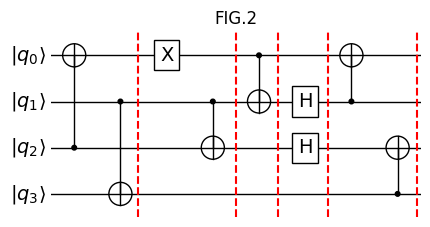

In [55]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(4)
c.add(gates.CNOT(2,0))
c.add(gates.CNOT(1,3))
c.add(gates.X(0))
c.add(gates.CNOT(1,2))
c.add(gates.CNOT(0,1))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1,0))
c.add(gates.CNOT(3,2))

ax, fig = plot_circuit(c)
ax.set_title('FIG.2')
# divide the circuit into time slices
for x in [0.83, 2.1,2.64, 3.3, 4.45]:  
    ax.axvline(x, color='red', linestyle='--')

plt.show()


Next, the logical qubits of the circuit must be mapped to the nodes of the graph. For our example a reasonable initial mapping is q1 → 1, q3 → 2, q2 → 3, q4 → 4 as shown in FIG. 3. This has the advantage that the qubits which interact in the first timestep are adjacent in the graph, and the same for the second timestep.

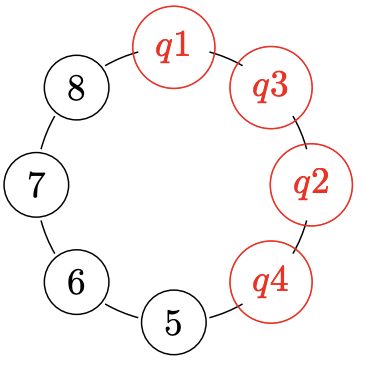

In [67]:
from IPython.display import Image
Image("images/FIG3.png", width=250, height=250)

FIG. 3. An initial mapping of logical qubits to nodes. Highlighted nodes are labelled with the mapped qubit.

However at the third timestep our luck has run out: the CNOT gate between q1 and q2 is not possible in the current configuration. We must add SWAP gates to exchange logical qubits to enable the desired two-qubit interactions. In the example there are two candidates: swapping nodes 1 and 3, or swapping nodes 2 and 3, yielding the configurations shown in FIG. 4

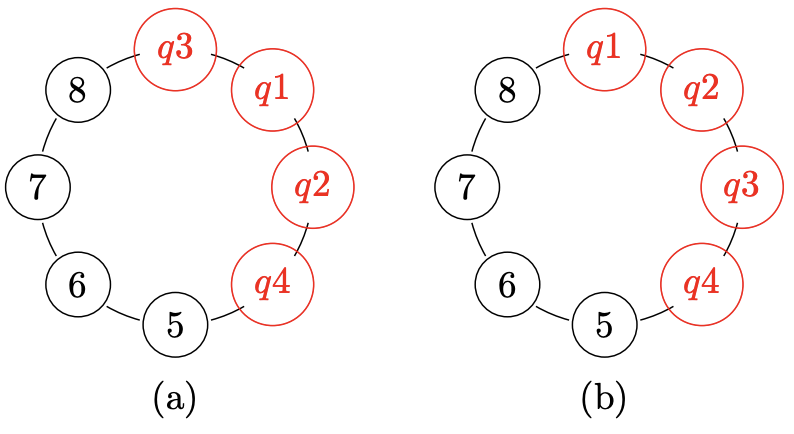

In [69]:
from IPython.display import Image
Image("images/FIG4.png", width=500, height=500)

FIG. 4. (a) Qubit mapping to nodes if q1 and q3 swap positions. (b) Qubit mapping to nodes if q2 and q3 swap positions.

Looking ahead to the final slice – slice 4 has no 2-qubit gates so can be ignored – we see that q3 and q4 will need to interact. In configuration (a) these qubits are distance 3 apart, and hence two additional swaps will be needed to bring them together. In configuration (b) however they are already adjacent. As we want to minimise the number of additional elements to our circuit we choose to swap nodes 2 and 3 to yield the final circuit shown in FIG. 5.

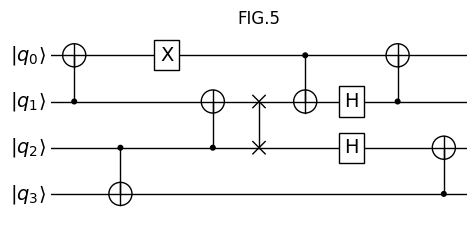

In [74]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

c = models.Circuit(4)
c.add(gates.CNOT(1,0))
c.add(gates.CNOT(2,3))
c.add(gates.X(0))
c.add(gates.CNOT(2,1))
c.add(gates.SWAP(2,1))
c.add(gates.CNOT(0,1))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1,0))
c.add(gates.CNOT(3,2))
ax, fig = plot_circuit(c)
ax.set_title('FIG.5')
plt.show()

While this was a tiny example we can see in microcosm all the key elements of the problem: the need to find a mapping of qubits to nodes; the notion of distance between qubits at the next
timestep; and the need to compute the permutation of the nodes to enable the next timestep. It should be clear even from this small example that as the size of the circuit increases the number of candidate swaps increases dramatically. Further, if we have to swap several pairs of qubits at the same time, improving the situation for one pair may worsen the situation for another pair. There is a clear arbitrage to apply to bring all the pairs together as soon as possible. Our goal is to optimise the circuit globally so finding optimal mappings between timesteps is
not sufficient. It is necessary to evaluate candidate mappings across multiple timesteps; this is the core of a good routing algorithm.

## B. SWAP synthesis and routing

In the preceding section we described the routing problem in terms of inserting SWAP gates into
the circuit. However not all device technologies offer SWAP as a primitive operation. Superconducting devices, for example, typically offer a single 2-qubit interaction from which all other gates,
including the SWAP, must be constructed. As a further complication, these interactions may be
asymmetric. For example, in some devices, the 2-qubit interaction is a CNOT where one qubit is always the control and the other always the target. The graph representing the machine is therefore directed, as shown in FIG. 6, where the direction indicates the orientation of the gate. This complication is easily removed by the usual trick of inserting Hadamard gates, as FIG. 7.

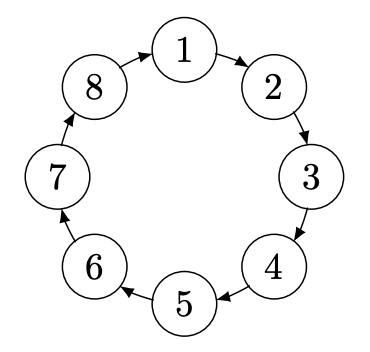

In [77]:
from IPython.display import Image
Image("images/FIG6.png", width=300, height=300)


FIG. 6. Architecture with one-way connectivity constraint.

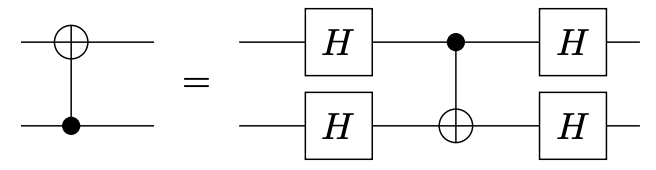

In [79]:
from IPython.display import Image
Image("images/FIG7.png", width=600, height=600)


Hence the swap gate can be implemented by three (unidirectional) CNOTS and four Hadamards, as in FIG. 8.

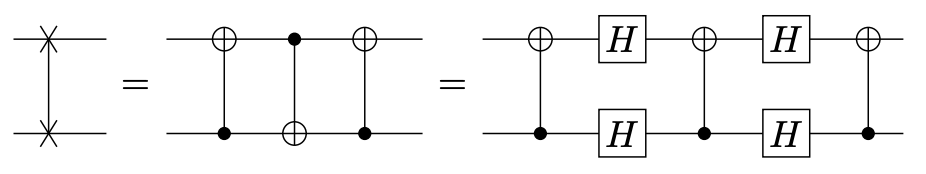

In [81]:
from IPython.display import Image
Image("images/FIG8.png", width=800, height=800)

FIG. 8. Representation of a SWAP gate in terms of three consecutive CNOT and its inverted representation for a directed graph.

Consider running our routed quantum circuit on the directed architecture of FIG. 6. As this
graph constrains the direction of interactions, the quantum circuit we produced is no longer valid. We account for this using the inversion in FIG. 7, producing the circuit shown in FIG.9. Many simplifications are possible on the resulting circuit, but care must be taken to ensure that the simplified circuit is still conformant to the architecture digraph.

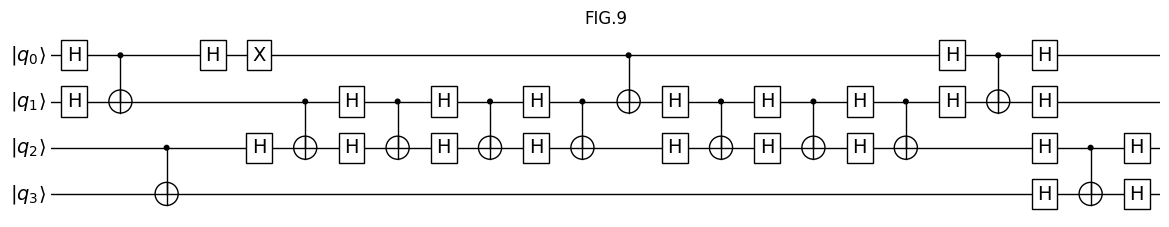

In [94]:
import matplotlib.pyplot as plt
from qibo import gates, models
from qibo.ui import plot_circuit

def directional_CNOT(circuit, q0, q1):
    circuit.add(gates.H(q0))
    circuit.add(gates.H(q1))
    circuit.add(gates.CNOT(q1, q0))
    circuit.add(gates.H(q0))
    circuit.add(gates.H(q1))

c = models.Circuit(4)
c.add(gates.H(0))
c.add(gates.H(1))
c.add(gates.CNOT(0,1))
c.add(gates.CNOT(2,3))
c.add(gates.H(0))
c.add(gates.X(0))
c.add(gates.H(2))
c.add(gates.CNOT(1,2))
directional_CNOT(c, 2, 1)
c.add(gates.CNOT(1,2))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1,2))
c.add(gates.CNOT(0,1))
directional_CNOT(c,2,1)
c.add(gates.CNOT(1,2))
c.add(gates.H(1))
c.add(gates.H(2))
c.add(gates.CNOT(1,2))
directional_CNOT(c,1,0)
directional_CNOT(c,3,2)
ax, fig = plot_circuit(c)
ax.set_title('FIG.9')
plt.show()